In [2]:
import sys
sys.path.append("../lropy")

%load_ext autoreload
%autoreload complete

In [3]:
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sb
import spiceypy as spice

from datetime import datetime

In [4]:
from lropy.analysis.spice_tools import generate_lro_ephemeris, as_et, as_utc, get_lro_beta_angle
from lropy.analysis.plotting import format_plot, save_plot
from lropy.analysis.spice_tools import init_spice_lro
from lropy.constants import JULIAN_DAY, lro_period, astronomical_unit

In [5]:
get_lro_beta_angle(as_et("2010 JUN 28 15:00:00"))

88.88225981064335

In [6]:
get_lro_beta_angle(as_et("2011 SEP 30 00:00:00"))

-4.400454878026025

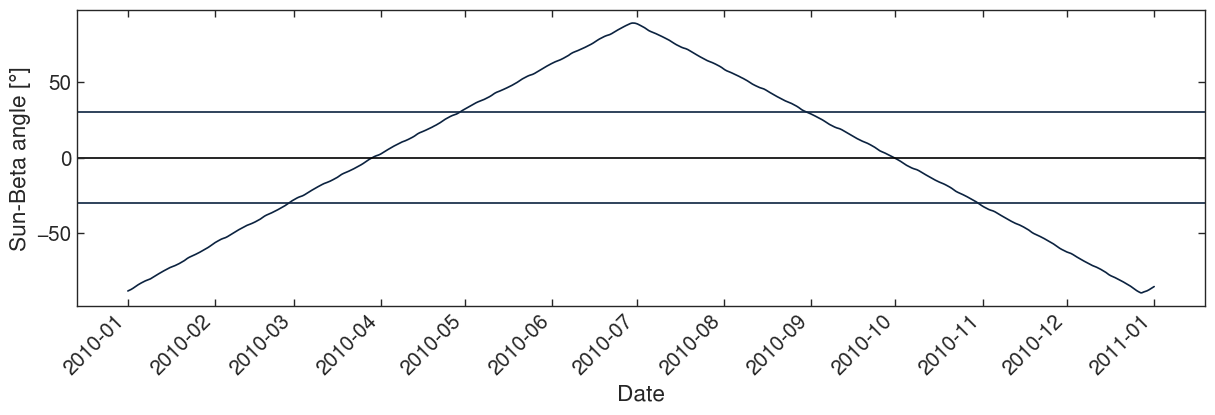

In [18]:
def plot_beta_angle():
    fig, ax = plt.subplots(figsize=(12, 4))

    t_start = as_et("2010 JAN 1 00:00:00")
    days = 365

    tt = np.linspace(t_start, t_start + days * 24 * 3600, 1000)
    ax.plot(pd.to_datetime([as_utc(t, sec_prec=6) for t in tt]), np.vectorize(get_lro_beta_angle)(tt))

    ax.axhline(0, c="black")
    ax.axhline(-30)
    ax.axhline(30)

    ax.set_xlabel("Date")
    ax.set_ylabel("Sun-Beta angle [°]")

    plt.xticks(rotation=45, ha='right')
    ax.set_yticks(np.arange(-90, 91, 30))

    format_plot(x_major_locator=matplotlib.dates.MonthLocator(interval=1))

plot_beta_angle()

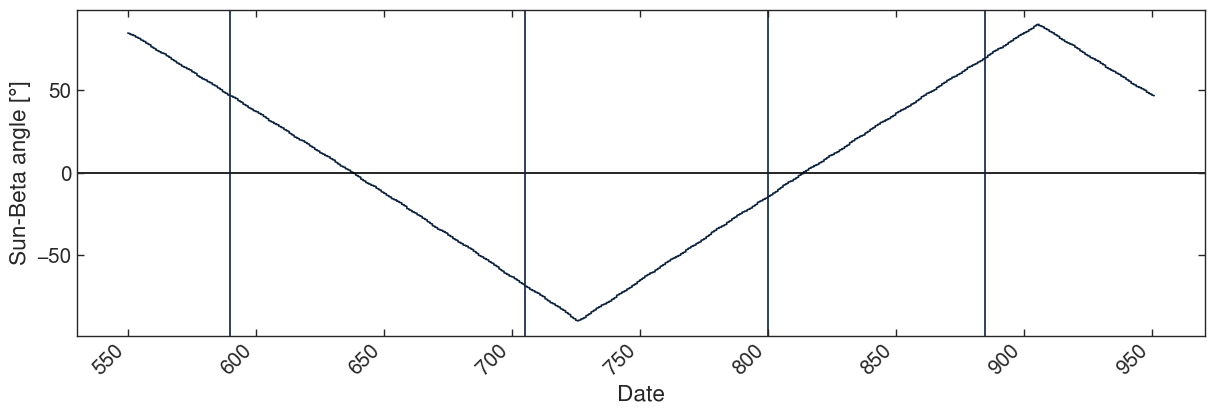

In [15]:
def plot_beta_angle_doy():
    fig, ax = plt.subplots(figsize=(12, 4))

    t_start = as_et("2009 JAN 1 00:00:00")

    tt = np.linspace(t_start + 550 * JULIAN_DAY, t_start + 950 * JULIAN_DAY, 1000)
    idx = pd.to_datetime([as_utc(t, sec_prec=6) for t in tt])
    idx = idx.dayofyear + (idx.year - 2009) * 365
    ax.plot(idx, np.vectorize(get_lro_beta_angle)(tt))

    ax.axhline(0, c="black")
    ax.axvline(590)
    ax.axvline(705)
    ax.axvline(800)
    ax.axvline(885)

    ax.set_xlabel("Date")
    ax.set_ylabel("Sun-Beta angle [°]")

    plt.xticks(rotation=45, ha='right')
    ax.set_yticks(np.arange(-90, 91, 30))

    format_plot()

plot_beta_angle_doy()

In [ ]:
def plot_moon_sun_distance():
    def distance(t):
        return get_distance("Sun", "Moon", t)

    fig, ax = plt.subplots(figsize=(12, 4))

    t_start = as_et("2010 JAN 1 00:00:00")
    days = 365

    tt = np.linspace(t_start, t_start + days * 24 * 3600, 100)
    dd = np.vectorize(distance)(tt)
    ax.plot(pd.to_datetime([as_utc(t, sec_prec=6) for t in tt]), dd)

    print(f"Minimum distance: {np.min(dd):.2f} km")
    print(f"Maximum distance: {np.max(dd):.2f} km")
    print(f"Average distance: {np.mean(dd):.2f} km")

    ax.set_xlabel("Date")
    ax.set_ylabel("Distance [km]")

    plt.xticks(rotation=45, ha='right')

    format_plot()

plot_moon_sun_distance()

Minimum distance: 146757375102.34 km
Maximum distance: 152460762421.49 km
Average distance: 149601851616.41 km


In [ ]:
def plot_moon_lro_distance():
    def distance(t):
        return np.linalg.norm(spice.spkpos("LRO", t, "ECLIPJ2000", "NONE", "Moon")[0]) / 1e3

    fig, ax = plt.subplots(figsize=(12, 4))

    t_start = as_et("2010 JUN 26 09:00:00")

    tt = np.linspace(t_start, t_start + 2 * 113 * 60, 1000)
    dd = np.vectorize(distance)(tt)
    ax.plot(pd.to_datetime([as_utc(t, sec_prec=6) for t in tt]), dd)

    ax.set_xlabel("Date")
    ax.set_ylabel("Distance [km]")

    plt.xticks(rotation=45, ha='right')

    format_plot()

plot_moon_lro_distance()

Closest in January, farthest in July

# FD and RS ephemerides

In [ ]:
t_start = as_et("2010 JUN 1 00:00:00")
days = 13

tt = np.linspace(t_start, t_start + days * 24 * 3600, 1000)

In [ ]:
spice.kclear()
spice.furnsh("../../tudat-bundle/spice/lro/data/spk/lrorg_2010091_2010182_v01.bsp")
pos_fd = [spice.spkpos("Moon", t, "ECLIPJ2000", "NONE", "LRO")[0] for t in tt]

In [ ]:
spice.kclear()

spice.furnsh("../../tudat-bundle/spice/lrors/data/spk/LRO_NO_10_201311_GRGM900C_L600.BSP")
pos_rs = [spice.spkpos("Moon", t, "ECLIPJ2000", "NONE", "LRO")[0] for t in tt]

init_spice_lro()

Text(0, 0.5, 'Difference [m]')

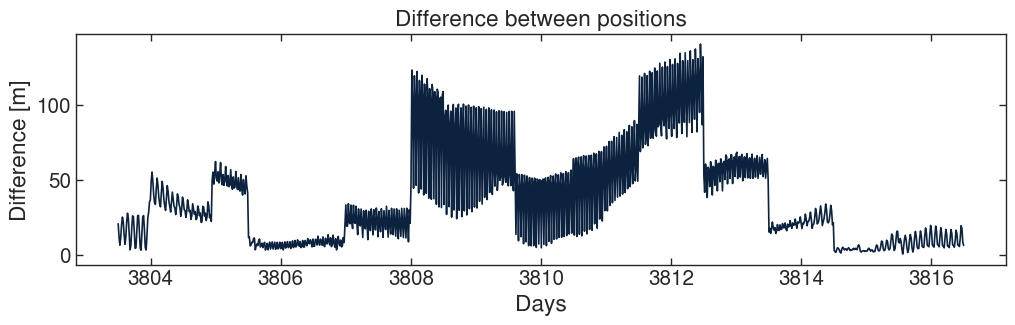

In [ ]:
plt.plot(tt / JULIAN_DAY, [np.linalg.norm(rs - fd) * 1e3 for rs, fd in zip(pos_rs, pos_fd)])
plt.title("Difference between positions")
plt.xlabel("Days")
plt.ylabel("Difference [m]")